In [1]:
!pip install yellowbrick
!pip install scikit-learn -U
!pip install -q ucimlrepo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 46.7 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spaghetti 1.7.6 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
spopt 0.6.1 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.


In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier,MLPRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
import json
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import LearningCurveDisplay, learning_curve
from sklearn.model_selection import (
    ParameterGrid,
    ValidationCurveDisplay,
    validation_curve,
)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from yellowbrick.model_selection import FeatureImportances, LearningCurve, ValidationCurve
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from ucimlrepo import fetch_ucirepo 

TEST = True

# Load Data

In [3]:
dframex=pd.read_csv("/kaggle/input/playground-series-s4e8/train.csv", index_col='id')
testframe=pd.read_csv("/kaggle/input/playground-series-s4e8/test.csv", index_col='id')
original = fetch_ucirepo(id=848)['data']['original']

In [4]:
testframe.head()

,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
id,,,,,,,,,,,,,,,,,,,,
3116945,8.64,x,NaN,n,t,NaN,NaN,w,11.13,17.12,b,NaN,w,u,w,t,g,NaN,d,a
3116946,6.90,o,t,o,f,NaN,c,y,1.27,10.75,NaN,NaN,n,NaN,NaN,f,f,NaN,d,a
3116947,2.00,b,g,n,f,NaN,c,n,6.18,3.14,NaN,NaN,n,NaN,NaN,f,f,NaN,d,s
3116948,3.47,x,t,n,f,s,c,n,4.98,8.51,NaN,NaN,w,NaN,n,t,z,NaN,d,u
3116949,6.17,x,h,y,f,p,NaN,y,6.73,13.70,NaN,NaN,y,NaN,y,t,NaN,NaN,d,u


# Clean Data

In [5]:
#Replace NaN in super dirty columns with "Unknown" label
#for col in ["spore-print-color", "veil-color", "veil-type", "stem-root", "stem-surface"]:
#    dframex[col] = dframex[col].fillna("Unknown")
#    testframe[col] = testframe[col].fillna("Unknown")
#dframex=dframex.head(5000)

In [6]:
#dframex=dframex.drop(["spore-print-color","veil-color","veil-type","stem-root","stem-surface"],axis=1)
#dframex=dframex.dropna()
dframex=dframex.head(5000)

In [7]:
y = dframex.pop('class')
y = y.apply(lambda x: 0 if x == 'e' else 1)
dframe=dframex

float_features = ['cap-diameter', 'stem-height', 'stem-width']
categorical_columns = []
for col in dframe.columns.tolist():
    if col not in float_features:
        categorical_columns.append(col)
        categories = sorted(list(set(original[col].dropna())))
        dtype = pd.CategoricalDtype(categories=categories,
                                   ordered=False)
        dframe.loc[~dframe[col].isin(categories), col] = "missing"
        if TEST:
            testframe.loc[~testframe[col].isin(categories), col] = "missing"
    else:
        dtype = np.float32
        dframe[col].fillna(dframe[col].mean())
        if TEST:
            testframe[col].fillna(testframe[col].mean())
    dframe[col] = dframe[col].astype(dtype)
    if TEST:
        testframe[col] = testframe[col].astype(dtype)

In [8]:
print(dframe.isnull().sum())
print(testframe.isnull().sum())

cap-diameter               0
cap-shape                  0
cap-surface             1083
cap-color                  0
does-bruise-or-bleed       0
gill-attachment          805
gill-spacing            2054
gill-color                 2
stem-height                0
stem-width                 0
stem-root               4473
stem-surface            3141
stem-color                 1
veil-type               4761
veil-color              4410
has-ring                   0
ring-type                207
spore-print-color       4563
habitat                    2
season                     0
dtype: int64
cap-diameter                  7
cap-shape                   368
cap-surface              447295
cap-color                   281
does-bruise-or-bleed         75
gill-attachment          350143
gill-spacing             839680
gill-color                  328
stem-height                   1
stem-width                    0
stem-root               1838125
stem-surface            1321738
stem-color             

In [9]:
"""
# Convert to categorical or float32
float_features = ['cap-diameter', 'stem-height', 'stem-width']
cat_features = [f for f in initial_features if f not in float_features]
for feature in initial_features:
    if feature in cat_features:
        categories = sorted(list(set(original[feature].dropna())))
        dtype = pd.CategoricalDtype(categories=categories,
                                    ordered=False)
        print(f"{feature:30} {len(dtype.categories)}")
        train.loc[~train[feature].isin(categories), feature] = np.nan
        if TEST:
            test.loc[~test[feature].isin(categories), feature] = np.nan
    else:
        dtype = np.float32
    train[feature] = train[feature].astype(dtype)
    original[feature] = original[feature].astype(dtype)
    if COMPUTE_TEST_PRED:
        test[feature] = test[feature].astype(dtype)
"""

'\n# Convert to categorical or float32\nfloat_features = [\'cap-diameter\', \'stem-height\', \'stem-width\']\ncat_features = [f for f in initial_features if f not in float_features]\nfor feature in initial_features:\n    if feature in cat_features:\n        categories = sorted(list(set(original[feature].dropna())))\n        dtype = pd.CategoricalDtype(categories=categories,\n                                    ordered=False)\n        print(f"{feature:30} {len(dtype.categories)}")\n        train.loc[~train[feature].isin(categories), feature] = np.nan\n        if TEST:\n            test.loc[~test[feature].isin(categories), feature] = np.nan\n    else:\n        dtype = np.float32\n    train[feature] = train[feature].astype(dtype)\n    original[feature] = original[feature].astype(dtype)\n    if COMPUTE_TEST_PRED:\n        test[feature] = test[feature].astype(dtype)\n'

In [10]:
print(dframe.info())
print(testframe.info())

<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 0 to 4999
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   cap-diameter          5000 non-null   float32 
 1   cap-shape             5000 non-null   category
 2   cap-surface           3917 non-null   category
 3   cap-color             5000 non-null   category
 4   does-bruise-or-bleed  5000 non-null   category
 5   gill-attachment       4195 non-null   category
 6   gill-spacing          2946 non-null   category
 7   gill-color            4998 non-null   category
 8   stem-height           5000 non-null   float32 
 9   stem-width            5000 non-null   float32 
 10  stem-root             527 non-null    category
 11  stem-surface          1859 non-null   category
 12  stem-color            4999 non-null   category
 13  veil-type             239 non-null    category
 14  veil-color            590 non-null    category
 15  has-ring 

In [ ]:
ct = make_column_transformer(
    (OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_columns),
    remainder='passthrough'
)

encoded_array = ct.fit_transform(dframe)
if TEST:
    test_array = ct.transform(testframe)

feature_names = ct.get_feature_names_out()

encoded_df = pd.DataFrame(encoded_array, columns=feature_names)
if TEST:
    test_df=pd.DataFrame(test_array,columns=feature_names, index = testframe.index)

columns=encoded_df.columns.to_list()
columns_map=[(columns[j],columns[j]) for j in range(0,len(columns)) if "remainder" not in columns[j]]
columns_map.append(("remainder__stem-width","stem-width"))
columns_map.append(("remainder__stem-height","stem-height"))
columns_map.append(("remainder__cap-diameter","cap-diameter"))
columns_map.append(("remainder__class","class"))
columns_map.append(("remainder__id","id"))
mapping_dict=dict()
for x in columns_map:
    mapping_dict.update({x[0]:x[1]})
#print(columns_map)
encoded_df=encoded_df.rename(columns=mapping_dict)
if TEST:
    test_df=test_df.rename(columns=mapping_dict)
dframe=encoded_df
if TEST:
    testframe=test_df
#print(dframe.shape)
#print(dframe.head())

In [12]:
print(testframe.head())

         onehotencoder__cap-shape_b  onehotencoder__cap-shape_c  \
id                                                                
3116945                         0.0                         0.0   
3116946                         0.0                         0.0   
3116947                         1.0                         0.0   
3116948                         0.0                         0.0   
3116949                         0.0                         0.0   

         onehotencoder__cap-shape_f  onehotencoder__cap-shape_o  \
id                                                                
3116945                         0.0                         0.0   
3116946                         0.0                         1.0   
3116947                         0.0                         0.0   
3116948                         0.0                         0.0   
3116949                         0.0                         0.0   

         onehotencoder__cap-shape_p  onehotencoder__cap-shap

# EDA


In [13]:
print(testframe.info())
print("\nDataset shape:", dframe.shape)
print(testframe.describe())
print(testframe.isnull().sum())
"""
for col in list(testframe.columns:
    if testframe[col].isnull().sum()>0:
        print(col)
"""
testframe = testframe.fillna(0)

<class 'pandas.core.frame.DataFrame'>
Index: 2077964 entries, 3116945 to 5194908
Columns: 131 entries, onehotencoder__cap-shape_b to stem-width
dtypes: float64(131)
memory usage: 2.0 GB
None

Dataset shape: (5000, 131)
       onehotencoder__cap-shape_b  onehotencoder__cap-shape_c  \
count                2.077964e+06                2.077964e+06   
mean                 1.019647e-01                3.341540e-02   
std                  3.026020e-01                1.797187e-01   
min                  0.000000e+00                0.000000e+00   
25%                  0.000000e+00                0.000000e+00   
50%                  0.000000e+00                0.000000e+00   
75%                  0.000000e+00                0.000000e+00   
max                  1.000000e+00                1.000000e+00   

       onehotencoder__cap-shape_f  onehotencoder__cap-shape_o  \
count                2.077964e+06                2.077964e+06   
mean                 2.176939e-01                3.463583e-02   


In [14]:
print(testframe.head())

         onehotencoder__cap-shape_b  onehotencoder__cap-shape_c  \
id                                                                
3116945                         0.0                         0.0   
3116946                         0.0                         0.0   
3116947                         1.0                         0.0   
3116948                         0.0                         0.0   
3116949                         0.0                         0.0   

         onehotencoder__cap-shape_f  onehotencoder__cap-shape_o  \
id                                                                
3116945                         0.0                         0.0   
3116946                         0.0                         1.0   
3116947                         0.0                         0.0   
3116948                         0.0                         0.0   
3116949                         0.0                         0.0   

         onehotencoder__cap-shape_p  onehotencoder__cap-shap

In [15]:
"""
for col in dframe.select_dtypes(include=['object']).columns:
    print(f"\nUnique values in {col}:")
    print(dframe[col].value_counts())
"""    

'\nfor col in dframe.select_dtypes(include=[\'object\']).columns:\n    print(f"\nUnique values in {col}:")\n    print(dframe[col].value_counts())\n'

In [16]:
# correlation_matrix = dframe[numerical_cols].corr()
# plt.figure(figsize=(12, 10))
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
# plt.title('Correlation Matrix')
# plt.show()

In [ ]:

# target_counts = dframe['class'].value_counts()


# plt.figure(figsize=(10, 8))
# plt.pie(target_counts.values, labels=target_counts.index, autopct='%1.1f%%', startangle=90)
# plt.title('Distribution of Target Classes')
# plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
# plt.show()

# Boilerplate


In [18]:
X=dframe
scaler = StandardScaler()
print(X)
#X=X[numerical_cols]
print(X.head(10))

      onehotencoder__cap-shape_b  onehotencoder__cap-shape_c  \
0                            0.0                         0.0   
1                            0.0                         0.0   
2                            0.0                         0.0   
3                            0.0                         0.0   
4                            0.0                         0.0   
...                          ...                         ...   
4995                         0.0                         0.0   
4996                         0.0                         0.0   
4997                         0.0                         0.0   
4998                         0.0                         0.0   
4999                         0.0                         0.0   

      onehotencoder__cap-shape_f  onehotencoder__cap-shape_o  \
0                            1.0                         0.0   
1                            0.0                         0.0   
2                            1.0       

In [19]:
if not TEST:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
if TEST:
    X_train = X
    y_train = y
    X_test = testframe
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

In [20]:
def error_rate(y_true, y_pred):
    return 1 - accuracy_score(y_true, y_pred)

error_rate_scorer = make_scorer(error_rate)

In [21]:
test_preds=dict()

# Trying out Yellowbrick

### Feature Importance

In [ ]:
if not TEST:
    model = DecisionTreeClassifier()
    model.fit(X_train_scaled, y_train)
    viz = FeatureImportances(model)
    viz.fit(X_train_scaled, y_train)
    viz.show()

### Learning Curve

In [ ]:
if not TEST:
    model = DecisionTreeClassifier()
    viz = LearningCurve(model)
    viz.fit(X_train_scaled, y_train)
    viz.show()

# Decision Trees

In [24]:
dt = DecisionTreeClassifier(random_state=42, ccp_alpha=0.01)
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)
test_preds.update({"dt":dt_pred})
if not TEST:
    print("Decision Tree Accuracy:", accuracy_score(y_test, dt_pred))

In [25]:
if not TEST:
    dt=DecisionTreeClassifier(random_state=42, ccp_alpha=0.01)
    train_sizes, train_scores, test_scores = learning_curve(dt, X_train, y_train, cv=5, scoring=error_rate_scorer)
    display = LearningCurveDisplay(
        train_sizes=train_sizes,
        train_scores=train_scores, 
        test_scores=test_scores, 
        score_name="Loss"
    )
    display.plot()
    plt.show()

## Yellowbrick - Learning Curve

In [26]:
if not TEST:
    model = DecisionTreeClassifier()
    viz = LearningCurve(model)
    viz.fit(X_train_scaled, y_train)
    viz.show()

# Gradient Boosting

In [27]:
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb.fit(X_train_scaled, y_train)
gb_pred = gb.predict(X_test)
test_preds.update({"gb":gb_pred})
if not TEST:
    print("Gradient Boosting Accuracy:", accuracy_score(y_test, gb_pred))

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


In [28]:
if not TEST:
    gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
    train_sizes, train_scores, test_scores = learning_curve(gb, X_train_scaled, y_train, cv=5, scoring=error_rate_scorer)
    display = LearningCurveDisplay(
        train_sizes=train_sizes,
        train_scores=train_scores, 
        test_scores=test_scores, 
        score_name="Loss"
    )
    display.plot()
    plt.show()

## Yellowbrick- Learning Curve

In [29]:
#TODO
if not TEST:
    model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=7, random_state=42)
    viz = LearningCurve(model)
    viz.fit(X_train_scaled, y_train)
    viz.show()

### Yellowbrick - Validation Curve

In [30]:
if not TEST:
    model = GradientBoostingClassifier( learning_rate=0.1, max_depth=5, random_state=42)
    viz = ValidationCurve(model, param_name="n_estimators", param_range=np.arange(100,200,step=10))
    viz.fit(X_train_scaled, y_train)
    viz.show()

### Yellowbrick- Validation Curve

In [31]:
if not TEST:
    model = GradientBoostingClassifier( n_estimators=100,learning_rate=0.1, random_state=42)
    viz = ValidationCurve(model, param_name="max_depth", param_range=np.arange(2,11))
    viz.fit(X_train_scaled, y_train)
    viz.show()

# Support Vector Machines

## RBF Kernel

In [32]:
svm_rbf = SVC(kernel='rbf', random_state=42)
svm_rbf.fit(X_train_scaled, y_train)
svm_rbf_pred = svm_rbf.predict(X_test_scaled)
test_preds.update({"svm_rbf":svm_rbf_pred})
if not TEST:
    print("SVM (RBF Kernel) Accuracy:", accuracy_score(y_test, svm_rbf_pred))

In [33]:
if not TEST:
    svc=SVC(kernel='rbf', random_state=42)
    train_sizes, train_scores, test_scores = learning_curve(svc, X_train_scaled, y_train, cv=5, scoring=error_rate_scorer)
    display = LearningCurveDisplay(
        train_sizes=train_sizes,
        train_scores=train_scores, 
        test_scores=test_scores, 
        score_name="Loss"
    )
    display.plot()
    plt.show()

### Yellowbrick - Learning Curve

In [34]:
if not TEST:
    model = SVC(kernel='rbf', random_state=42)
    viz = LearningCurve(model)
    viz.fit(X_train_scaled, y_train)
    viz.show()

## Poly Kernel

In [35]:
svm_poly = SVC(kernel='poly', random_state=42)
svm_poly.fit(X_train_scaled, y_train)
svm_poly_pred = svm_poly.predict(X_test_scaled)
test_preds.update({"svm_poly":svm_poly_pred})
if not TEST:
    print("SVM (Poly Kernel) Accuracy:", accuracy_score(y_test, svm_poly_pred))

In [36]:
if not TEST:
    svm_poly = SVC(kernel='poly', random_state=42)
    train_sizes, train_scores, test_scores = learning_curve(svm_poly, X_train_scaled, y_train, cv=5, scoring=error_rate_scorer)
    display = LearningCurveDisplay(
        train_sizes=train_sizes,
        train_scores=train_scores, 
        test_scores=test_scores, 
        score_name="Loss"
    )
    display.plot()
    plt.show()

### Yellowbrick - Learning Curve

In [37]:
if not TEST:
    model = SVC(kernel='poly', random_state=42)
    viz = LearningCurve(model)
    viz.fit(X_train_scaled, y_train)
    viz.show()

# kNN

# Learning Curve

In [38]:
if not TEST:
    # Instantiate the clustering model and visualizer
    model = KNeighborsClassifier()
    visualizer = LearningCurve(model, random_state=42)
    visualizer.fit(X_train_scaled, y_train)        # Fit the data to the visualizer
    visualizer.show()           # Finalize and render the figure

## Validation Curve

In [39]:
if not TEST:
    model = KNeighborsClassifier()
    viz = ValidationCurve(model, param_name="n_neighbors", param_range=np.arange(2,22))
    viz.fit(X_train_scaled, y_train)
    viz.show()

# Neural Networks

## MLP Classifier- Learning Curve

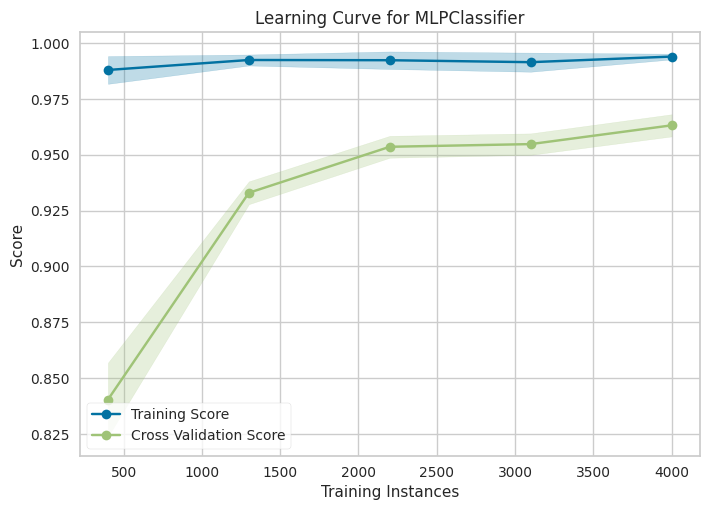

<Axes: title={'center': 'Learning Curve for MLPClassifier'}, xlabel='Training Instances', ylabel='Score'>

In [ ]:
# Make classifier and visualizer curve obj
model = MLPClassifier(max_iter=1000,alpha=1e-5,
                    hidden_layer_sizes=(5, 2), random_state=1)
model.fit(X_train_scaled, y_train)
viz = LearningCurve(model)
viz.fit(X_train_scaled, y_train)
viz.show()

## MLP Classifier- Validation Curve

In [41]:
if not TEST:
    #model = MLPClassifier(max_iter=1000)
    viz = ValidationCurve(model, param_name="alpha", param_range=np.linspace(1e-5,1e-4,num=10))
    viz.fit(X_train_scaled, y_train)
    viz.show()

## MLP Classifier - Val Curve

In [42]:
if not TEST:
    #model = MLPClassifier(alpha=1e-5)
    viz = ValidationCurve(model, param_name="max_iter", param_range=np.arange(200,1000,step=100))
    viz.fit(X_train_scaled, y_train)
    viz.show()

In [43]:
mlp_preds = model.predict(X_test_scaled)
test_preds.update({"mlp": mlp_preds})

# BOILERPLATE 2 


In [44]:
def SelBest(arr:list, X:int)->list:
    '''
    returns the set of X configurations with shorter distance
    '''
    dx=np.argsort(arr)[:X]
    return arr[dx]

def load_data(ds):
    df = pd.read_csv("data/" + ds)
    X, y = df.iloc[:, :-1], df.iloc[:, -1]
    X, y = X.to_numpy(), y.to_numpy()
    return X, y

def load_data_df(ds):
    df = pd.read_csv("data/" + ds)
    X, y = df.iloc[:, :-1], df.iloc[:, -1]
    # X, y = X.to_numpy(), y.to_numpy()
    return X, y
    
def gmm_js(gmm_p, gmm_q, n_samples=10**5):
    # https://towardsdatascience.com/gaussian-mixture-model-clusterization-how-to-select-the-number-of-components-clusters-553bef45f6e4
    
    X = gmm_p.sample(n_samples)[0]
    log_p_X = gmm_p.score_samples(X)
    log_q_X = gmm_q.score_samples(X)
    log_mix_X = np.logaddexp(log_p_X, log_q_X)

    Y = gmm_q.sample(n_samples)[0]
    log_p_Y = gmm_p.score_samples(Y)
    log_q_Y = gmm_q.score_samples(Y)
    log_mix_Y = np.logaddexp(log_p_Y, log_q_Y)

    return np.sqrt((log_p_X.mean() - (log_mix_X.mean() - np.log(2))
            + log_q_Y.mean() - (log_mix_Y.mean() - np.log(2))) / 2)

def generate_kmeans_SV_ICD_plots(X, k):
    plot_nums = len(k)
    fig, axes = plt.subplots(plot_nums, 2, figsize=[25, 40])
    col_ = 0
    for i in k:
        kmeans = KMeans(n_clusters=i, algorithm="full")
        visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick', ax=axes[col_][0])
        visualizer.fit(X)
        visualizer.finalize()
        
        kmeans = KMeans(n_clusters=i, algorithm="full")
        visualizer = InterclusterDistance(kmeans, ax=axes[col_][1])
        visualizer.fit(X)
        visualizer.finalize()
        
        col_+=1
    plt.show()
    
def generate_silhoutte_score_plot(X, k, model):
    n_clusters=np.arange(2, k)
    sils=[]
    sils_err=[]
    iterations=k
    for n in n_clusters:
        tmp_sil=[]
        for _ in range(iterations):
            clf=model(n).fit(X) 
            labels=clf.predict(X)
            sil=metrics.silhouette_score(X, labels, metric='euclidean')
            tmp_sil.append(sil)
        val=np.mean(SelBest(np.array(tmp_sil), int(iterations/5)))
        err=np.std(tmp_sil)
        sils.append(val)
        sils_err.append(err)
    plt.errorbar(n_clusters, sils, yerr=sils_err)
    plt.title("Silhouette Scores", fontsize=20)
    plt.xticks(n_clusters)
    plt.xlabel("N. of clusters ({})".format("Test"))
    plt.ylabel("Score")

def generate_distance_bw_gmms_plots(X, n):
    # https://towardsdatascience.com/gaussian-mixture-model-clusterization-how-to-select-the-number-of-components-clusters-553bef45f6e4
    
    n_clusters=np.arange(2, n)
    iterations=n
    results=[]
    res_sigs=[]
    for n in n_clusters:
        dist=[]

        for iteration in range(iterations):
            train, test=train_test_split(X, test_size=0.5)

            gmm_train=GaussianMixture(n, n_init=2).fit(train) 
            gmm_test=GaussianMixture(n, n_init=2).fit(test) 
            dist.append(gmm_js(gmm_train, gmm_test))
        selec=SelBest(np.array(dist), int(iterations/5))
        result=np.mean(selec)
        res_sig=np.std(selec)
        results.append(result)
        res_sigs.append(res_sig)


    plt.errorbar(n_clusters, results, yerr=res_sigs)
    plt.title("Distance between Train and Test GMMs", fontsize=20)
    plt.xticks(n_clusters)
    plt.xlabel("N. of components")
    plt.ylabel("Distance")
    plt.show()

def generate_bic_plot(X, n):
    n_clusters=np.arange(2, n)
    bics=[]
    bics_err=[]
    iterations=n
    for n in n_clusters:
        tmp_bic=[]
        for _ in range(iterations):
            gmm=GaussianMixture(n, n_init=2).fit(X) 

            tmp_bic.append(gmm.bic(X))
        val=np.mean(SelBest(np.array(tmp_bic), int(iterations/5)))
        err=np.std(tmp_bic)
        bics.append(val)
        bics_err.append(err)

    plt.errorbar(n_clusters,bics, yerr=bics_err, label='BIC')
    plt.title("BIC Scores", fontsize=20)
    plt.xticks(n_clusters)
    plt.xlabel("N. of components")
    plt.ylabel("Score")
    plt.legend()
    plt.show()
    plt.clf()
    
    plt.errorbar(n_clusters, np.gradient(bics), yerr=bics_err, label='BIC')
    plt.title("Gradient of BIC Scores", fontsize=20)
    plt.xticks(n_clusters)
    plt.xlabel("N. of components")
    plt.ylabel("grad(BIC)")
    plt.legend()
    plt.show()
    plt.clf()

# CLUSTERING

In [45]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, FastICA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

## PCA

In [46]:
if not TEST:
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_train)

## ICA

In [47]:
if not TEST:
    ica = FastICA(n_components=2, random_state=42)
    X_ica = ica.fit_transform(X_train)

## Kmeans

In [48]:
if not TEST:
    inertias = []
    silhouette_scores = []
    k_range = range(2, 11)

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X_train)
        inertias.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(X_train, kmeans.labels_))

In [49]:
if not TEST:
    # Plot elbow curve
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(k_range, inertias, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Inertia')
    plt.title('Elbow Method for Optimal k')

    # Plot silhouette scores
    plt.subplot(1, 2, 2)
    plt.plot(k_range, silhouette_scores, 'rx-')
    plt.xlabel('k')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score for Optimal k')
    plt.tight_layout()
    plt.show()


In [ ]:
if not TEST:
    optimal_k = 7 

    kmeans = KMeans(n_clusters=optimal_k, random_state=42)
    cluster_labels = kmeans.fit_predict(X_train)

In [ ]:
if not TEST:
    # Visualize everything
    plt.figure(figsize=(15, 5))

    # PCA
    plt.subplot(1, 3, 1)
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis')
    plt.title('PCA')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')

    # ICA
    plt.subplot(1, 3, 2)
    plt.scatter(X_ica[:, 0], X_ica[:, 1], c=cluster_labels, cmap='viridis')
    plt.title('ICA')
    plt.xlabel('First Independent Component')
    plt.ylabel('Second Independent Component')

    # K-means
    plt.subplot(1, 3, 3)
    plt.scatter(X_train_scaled[:, 0], X_train_scaled[:, 1], c=cluster_labels, cmap='viridis')
    plt.title('K-means Clustering')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')

    plt.tight_layout()
    plt.show()

In [52]:
print(test_preds.keys())
print(test_preds.values())

dict_keys(['dt', 'gb', 'svm_rbf', 'svm_poly', 'mlp'])
dict_values([array([0, 1, 1, ..., 1, 0, 0]), array([0, 1, 1, ..., 1, 1, 1]), array([0, 1, 1, ..., 1, 0, 0]), array([0, 1, 1, ..., 1, 0, 0]), array([0, 1, 0, ..., 1, 0, 0])])


# Ensemble Model Time:

In [ ]:
COMPUTE_TEST_PRED = True
#NTS: Not an improvement
"""
X = np.column_stack([test_preds[label] for label in test_preds.keys()]).astype(np.float64).clip(1e-15, 1-1e-15)
mask = ~ np.isnan(X).any(axis=1)
if COMPUTE_TEST_PRED:
    X_te = np.column_stack([test_pred[label] for label in test_preds.keys() if 'Ensemble' not in label]).astype(np.float64).clip(1e-15, 1-1e-15)
model = make_pipeline(FunctionTransformer(scipy.special.logit), LogisticRegression(max_iter=500))
test_preds['Ensemble (logistic)'] = np.full(len(X), np.nan)
test_preds['Ensemble (logistic)'][mask] = cross_val_predict(model,
                                               X[mask], targets_bool[mask],
                                               cv=crossval_kf, method='predict_proba')[:,1]
print(f"{Fore.GREEN}# Stacking ensemble (logistic)"
      f" mcc={matthews_corrcoef(targets_bool[mask], test_preds['Ensemble (logistic)'][mask] >= 0.5):.5f}"
      f" logloss={log_loss(targets_bool[mask], oof['Ensemble (logistic)'][mask]):.5f}{Style.RESET_ALL}")

model.fit(X[mask], targets_bool[mask])
print(pd.Series(model[-1].coef_.ravel(), index=[label for label in test_preds.keys() if 'Ensemble' not in label], name='weights'))

if COMPUTE_TEST_PRED:
    test_pred['Ensemble (logistic)'] = model.predict_proba(X_te)[:,1]
"""

'\nX = np.column_stack([test_preds[label] for label in test_preds.keys()]).astype(np.float64).clip(1e-15, 1-1e-15)\nmask = ~ np.isnan(X).any(axis=1)\nif COMPUTE_TEST_PRED:\n    X_te = np.column_stack([test_pred[label] for label in test_preds.keys() if \'Ensemble\' not in label]).astype(np.float64).clip(1e-15, 1-1e-15)\nmodel = make_pipeline(FunctionTransformer(scipy.special.logit), LogisticRegression(max_iter=500))\ntest_preds[\'Ensemble (logistic)\'] = np.full(len(X), np.nan)\ntest_preds[\'Ensemble (logistic)\'][mask] = cross_val_predict(model,\n                                               X[mask], targets_bool[mask],\n                                               cv=crossval_kf, method=\'predict_proba\')[:,1]\nprint(f"{Fore.GREEN}# Stacking ensemble (logistic)"\n      f" mcc={matthews_corrcoef(targets_bool[mask], test_preds[\'Ensemble (logistic)\'][mask] >= 0.5):.5f}"\n      f" logloss={log_loss(targets_bool[mask], oof[\'Ensemble (logistic)\'][mask]):.5f}{Style.RESET_ALL}")\n\nmod

In [54]:
if TEST:
    model_num = float(len(list(test_preds.keys())))
    pred_votes = np.zeros(testframe.shape[0])
    for label in list(test_preds.keys()):
        pred_votes = pred_votes + test_preds[label]
    pred_votes = pred_votes / model_num

# Submission

In [55]:
if TEST:
    sub = pd.Series(np.where(pred_votes >= 0.5, 'p', 'e'),
                    index=testframe.index,
                    name='class')
    sub.to_csv('submission.csv')
    !head submission.csv
    print(sub.head())

id,class
3116945,e
3116946,p
3116947,p
3116948,p
3116949,e
3116950,e
3116951,e
3116952,p
3116953,p
id
3116945    e
3116946    p
3116947    p
3116948    p
3116949    e
Name: class, dtype: object
